In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/instquality/")

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/instquality/")

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


### Function

In [ ]:
import os, time
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from IPython.display import display
from joblib import Parallel, delayed
import shap
import warnings

def filter_cols(cols, exclude_endings):
    return [c for c in cols if not any(c.endswith(ending) for ending in exclude_endings)]

def _yearwise_splits(years, min_train_years=8, stride=2):
    ys = np.asarray(years)
    uniq = np.sort(np.unique(ys))
    for k in range(min_train_years, len(uniq), stride):
        train = np.where(np.isin(ys, uniq[:k]))[0]
        val = np.where(ys == uniq[k])[0]
        yield train, val

def _rmse_for_param(param, X, y, years, model_type='lasso', l1_ratio=0.5, min_train_years=8, stride=2):
    rmse = []
    if model_type == 'lasso':
        model = Lasso(alpha=param, max_iter=2000, tol=1e-3, warm_start=False)
    elif model_type == 'ridge':
        model = Ridge(alpha=param)
    elif model_type == 'elastic':
        model = ElasticNet(alpha=param, l1_ratio=l1_ratio, max_iter=2000, tol=1e-3)
    else:
        raise ValueError(f"Unknown model_type: {model_type}")
    for tr, va in _yearwise_splits(years, min_train_years, stride):
        model.fit(X.iloc[tr], y.iloc[tr])
        pred = model.predict(X.iloc[va])
        rmse.append(np.sqrt(mean_squared_error(y.iloc[va], pred)))
    return param, float(np.mean(rmse)) if rmse else np.inf

def choose_param_expanding_fast(X, y, years, model_type='lasso', l1_ratio=0.5, min_train_years=8, stride=2, n_jobs=-1):
    if model_type == 'lasso':
        alphas = np.logspace(-4, 1, 20)
        cv_folds = []
        for tr, va in _yearwise_splits(years, min_train_years, stride):
            cv_folds.append((tr, va))

        if len(cv_folds) > 0:
            lasso_cv = LassoCV(alphas=alphas, cv=cv_folds, max_iter=2000, tol=1e-3, n_jobs=n_jobs)
            lasso_cv.fit(X, y)
            return lasso_cv.alpha_

    elif model_type == 'elastic':
        alphas = np.logspace(-4, 1, 20)
        cv_folds = []
        for tr, va in _yearwise_splits(years, min_train_years, stride):
            cv_folds.append((tr, va))

        if len(cv_folds) > 0:
            elastic_cv = ElasticNetCV(alphas=alphas, l1_ratio=[l1_ratio], cv=cv_folds,
                                    max_iter=2000, tol=1e-3, n_jobs=n_jobs)
            elastic_cv.fit(X, y)
            return elastic_cv.alpha_

    params_coarse = np.logspace(0, 5, 15) if model_type == 'ridge' else np.logspace(-4, 1, 12)
    coarse = Parallel(n_jobs=n_jobs)(
        delayed(_rmse_for_param)(p, X, y, years, model_type, l1_ratio, min_train_years, stride)
        for p in sorted(params_coarse, reverse=True)
    )
    p0 = min(coarse, key=lambda t: t[1])[0]
    low, high = p0/5, p0*5
    fine_grid = np.logspace(np.log10(low), np.log10(high), 8)
    fine = Parallel(n_jobs=n_jobs)(
        delayed(_rmse_for_param)(p, X, y, years, model_type, l1_ratio, min_train_years, stride)
        for p in sorted(fine_grid, reverse=True)
    )
    return min(fine, key=lambda t: t[1])[0]

def _fit_model_for_factor(factor, optimal_param, X_train, X_test, y_train_adj, y_test_adj,
                         y_train, y_test, spread_train, spread_test, model_type, l1_ratio, agnostic):
    param = optimal_param * factor
    if model_type == 'lasso':
        model = Lasso(alpha=param, max_iter=2000, tol=1e-3)
    elif model_type == 'ridge':
        model = Ridge(alpha=param)
    elif model_type == 'elastic':
        model = ElasticNet(alpha=param, l1_ratio=l1_ratio, max_iter=2000, tol=1e-3)

    model.fit(X_train, y_train_adj)
    y_pred_test_adj = model.predict(X_test)
    y_pred_train_adj = model.predict(X_train)

    if not agnostic:
        y_pred_test = spread_test + y_pred_test_adj
        y_pred_train = spread_train + y_pred_train_adj
    else:
        y_pred_test = y_pred_test_adj
        y_pred_train = y_pred_train_adj

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    active_vars = np.sum(model.coef_ != 0)

    if not agnostic:
        e_benchmark = y_test - spread_test
        e_model = y_test - y_pred_test
        dm_stat, dm_p = _dm_test(e_benchmark, e_model)
    else:
        dm_stat, dm_p = np.nan, np.nan

    return {
        'factor': factor,
        'param': param,
        'R²_train': r2_train,
        'R²_test': r2_test,
        'RMSE_test': rmse_test,
        'Active_vars': active_vars,
        'DM_stat': dm_stat,
        'DM_p': dm_p,
        'model': model,
        'predictions': y_pred_test
    }

def _dm_test(e0, e1):
    d = e0**2 - e1**2
    T = len(d)
    v = np.var(d, ddof=1)
    if T < 2 or v == 0 or np.isnan(v):
        return np.nan, np.nan
    stat = d.mean() / np.sqrt(v / T)
    pval = 2 * (1 - norm.cdf(abs(stat)))
    return stat, pval

def cluster_features(X_train, y_train=None, corr_threshold=0.75, method='complete'):
    def extract_core(var):
        suffixes = ['_delta3', '_delta', '_t-5', '_t-3', '_t-2', '_t-1', '_ma10', '_ma5', '_ma3']
        for s in suffixes:
            if var.endswith(s):
                return var[:-len(s)]
        return var

    core_groups = {}
    for v in X_train.columns:
        core = extract_core(v)
        core_groups.setdefault(core, []).append(v)

    cluster_map = {}
    representative_vars = []
    cluster_id = 0
    cluster_records = []

    for core, vars_in_core in core_groups.items():
        if len(vars_in_core) == 1:
            cluster_id += 1
            var = vars_in_core[0]
            cluster_map[cluster_id] = [var]
            representative_vars.append(var)
            cluster_records.append({'variable': var, 'cluster': cluster_id})
            continue

        corr_matrix = X_train[vars_in_core].corr().abs()
        distance_matrix = 1 - corr_matrix
        condensed_dist = squareform(distance_matrix, checks=False)
        linkage_matrix = linkage(condensed_dist, method=method)
        clusters = fcluster(linkage_matrix, t=1 - corr_threshold, criterion='distance')

        for subcluster_id in np.unique(clusters):
            cluster_id += 1
            cluster_vars = [vars_in_core[i] for i, c in enumerate(clusters) if c == subcluster_id]
            cluster_map[cluster_id] = cluster_vars

            if y_train is not None:
                corrs = X_train[cluster_vars].corrwith(y_train)
                rep_var = corrs.abs().idxmax()
            else:
                variances = X_train[cluster_vars].var()
                rep_var = variances.idxmax()

            representative_vars.append(rep_var)
            for v in cluster_vars:
                cluster_records.append({'variable': v, 'cluster': cluster_id})

    cluster_df = pd.DataFrame(cluster_records)
    return representative_vars, cluster_map, cluster_df

def extract_core_variable(var_name):
    suffixes = ['_delta3', '_delta', '_t-5', '_t-4', '_t-3', '_t-2', '_t-1',
                '_ma10', '_ma5', '_ma3']
    for suffix in suffixes:
        if var_name.endswith(suffix):
            return var_name[:-len(suffix)]
    return var_name

def aggregate_by_core_variable(importance_df):
    importance_df = importance_df.copy()
    importance_df['core_variable'] = importance_df['variable'].apply(extract_core_variable)

    agg_dict = {'variable': lambda x: list(x)}

    if 'shap_importance' in importance_df.columns:
        agg_dict['shap_importance'] = 'sum'
    if 'shap_importance_pct' in importance_df.columns:
        agg_dict['shap_importance_pct'] = 'sum'
    if 'selection_frequency' in importance_df.columns:
        agg_dict['selection_frequency'] = 'mean'
    if 'mean_coef' in importance_df.columns:
        agg_dict['mean_coef'] = 'mean'
    if 'std_coef' in importance_df.columns:
        agg_dict['std_coef'] = 'mean'

    core_agg = importance_df.groupby('core_variable').agg(agg_dict).reset_index()
    core_agg['n_variants'] = core_agg['variable'].apply(len)
    core_agg = core_agg.rename(columns={'variable': 'variants'})

    if 'shap_importance' in core_agg.columns:
        core_agg = core_agg.sort_values('shap_importance', key=abs, ascending=False)
    elif 'selection_frequency' in core_agg.columns:
        core_agg = core_agg.sort_values('selection_frequency', ascending=False)

    return core_agg

def identify_cross_variable_correlations(X, threshold=0.75):
    var_to_core = {var: extract_core_variable(var) for var in X.columns}

    corr_matrix = X.corr().abs()

    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            var1, var2 = corr_matrix.columns[i], corr_matrix.columns[j]
            corr_val = corr_matrix.iloc[i, j]

            core1 = var_to_core[var1]
            core2 = var_to_core[var2]

            if core1 != core2 and corr_val > threshold:
                high_corr_pairs.append({
                    'core_variable_1': core1,
                    'core_variable_2': core2,
                    'correlation': corr_val
                })

    if not high_corr_pairs:
        return pd.DataFrame()

    pairs_df = pd.DataFrame(high_corr_pairs)

    pairs_df['pair'] = pairs_df.apply(
        lambda row: tuple(sorted([row['core_variable_1'], row['core_variable_2']])),
        axis=1
    )

    result = pairs_df.loc[pairs_df.groupby('pair')['correlation'].idxmax()].copy()
    result = result[['core_variable_1', 'core_variable_2', 'correlation']].sort_values('correlation', ascending=False)
    result = result.reset_index(drop=True)

    return result

def calculate_shap_importance(model, X_test, max_samples=500):
    X_sample = X_test if len(X_test) <= max_samples else X_test.sample(max_samples, random_state=42)

    if hasattr(model, 'coef_'):
        explainer = shap.LinearExplainer(model, X_sample)
    else:
        explainer = shap.Explainer(model.predict, X_sample)

    shap_values = explainer(X_sample)

    if hasattr(shap_values, 'values'):
        shap_vals = shap_values.values
    else:
        shap_vals = shap_values

    mean_abs_shap = np.abs(shap_vals).mean(axis=0)

    shap_df = pd.DataFrame({
        'variable': X_test.columns,
        'shap_importance': mean_abs_shap,
        'shap_importance_pct': mean_abs_shap / mean_abs_shap.sum() * 100
    }).sort_values('shap_importance', ascending=False)

    return shap_df, shap_values

def stability_selection(X_train, y_train, model_type='lasso', alpha=None, l1_ratio=0.5,
                       n_iterations=100, subsample_frac=0.8, random_state=42):
    np.random.seed(random_state)
    n_samples = len(X_train)
    subsample_size = int(n_samples * subsample_frac)

    selection_counts = {col: 0 for col in X_train.columns}
    coef_values = {col: [] for col in X_train.columns}

    for i in range(n_iterations):
        idx = np.random.choice(n_samples, size=subsample_size, replace=False)
        X_sub = X_train.iloc[idx]
        y_sub = y_train.iloc[idx]

        if model_type == 'lasso':
            if alpha is None:
                model = LassoCV(max_iter=2000, tol=1e-3, n_jobs=-1, random_state=random_state+i)
            else:
                model = Lasso(alpha=alpha, max_iter=2000, tol=1e-3)
        elif model_type == 'elastic':
            if alpha is None:
                model = ElasticNetCV(l1_ratio=l1_ratio, max_iter=2000, tol=1e-3, n_jobs=-1, random_state=random_state+i)
            else:
                model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=2000, tol=1e-3)
        elif model_type == 'ridge':
            model = Ridge(alpha=alpha if alpha else 1.0)

        model.fit(X_sub, y_sub)

        for col, coef in zip(X_train.columns, model.coef_):
            if coef != 0:
                selection_counts[col] += 1
                coef_values[col].append(coef)

    stability_df = pd.DataFrame({
        'variable': X_train.columns,
        'selection_frequency': [selection_counts[col] / n_iterations for col in X_train.columns],
        'mean_coef': [np.mean(coef_values[col]) if coef_values[col] else 0 for col in X_train.columns],
        'std_coef': [np.std(coef_values[col]) if coef_values[col] else 0 for col in X_train.columns],
        'n_selections': [selection_counts[col] for col in X_train.columns]
    }).sort_values('selection_frequency', ascending=False)

    stability_df['stable'] = stability_df['selection_frequency'] >= 0.8

    return stability_df

def run_unified_regularized_regression(
    name_prefix="base",
    data_path="saved/df.dat",
    macro_cols=None,
    iq_cols=None,
    y_name="tgt_spread",
    spread_col="tgt_spread",
    year_col="year",
    split_year=2015,
    model_types=['lasso', 'ridge', 'elastic'],
    agnostic=True,
    param_factors=[0.5, 1.0, 2.0],
    l1_ratios=[0.5],
    use_clustering=True,
    corr_threshold=0.85,
    use_expanding_cv=True,
    min_train_years=8,
    cv_stride=2,
    r2_benchmark=None,
    rmse_benchmark=None,
    early_stop_threshold=0.10,
    stability_iterations=100,
    save_results=True,
    output_dir="specs",
    n_jobs=-1,
    parallel_param_factors=True,
    compute_shap=True,
    max_shap_samples=500,
    force_interpretability=False,
    r2_convergence_threshold=1e-4,
    r2_convergence_count=2
):
    print(f"\n{'='*80}")
    print(f"UNIFIED REGULARIZED REGRESSION: {name_prefix.upper()}")
    print(f"Research Question: ", end="")
    if agnostic:
        print("What macro/IQ variables are priced into spreads?")
    else:
        print("Do macro/IQ variables add incremental predictive power beyond mean reversion?")
    print(f"Specification: {'Agnostic (β unrestricted)' if agnostic else 'β=1 (fixed at mean reversion)'}")
    print(f"Models: {', '.join([m.upper() for m in model_types])}")
    if 'elastic' in model_types:
        print(f"Elastic Net L1 ratios: {l1_ratios}")
    if use_clustering:
        print(f"Feature clustering: ON (threshold={corr_threshold})")
    print(f"Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)")
    print(f"R² convergence: Stop after {r2_convergence_count} consecutive changes < {r2_convergence_threshold}")
    if force_interpretability:
        print("Force interpretability: ON (interpret even if DM test fails)")
    print(f"{'='*80}\n")
    start_time = time.time()

    df = pd.read_pickle(data_path)
    df = df[df[y_name].notna()]
    df[year_col] = df[year_col].astype(int)

    if macro_cols is None:
        macro_cols = []
    if iq_cols is None:
        iq_cols = []

    train_data = df[df[year_col] <= split_year].copy()
    test_data = df[df[year_col] > split_year].copy()

    print(f"Train: {train_data[year_col].min()}-{train_data[year_col].max()} ({len(train_data)} obs)")
    print(f"Test:  {test_data[year_col].min()}-{test_data[year_col].max()} ({len(test_data)} obs)\n")

    feature_cols = macro_cols + iq_cols
    if spread_col in feature_cols and not agnostic:
        feature_cols = [c for c in feature_cols if c != spread_col]

    X_train_raw = train_data[feature_cols].copy()
    X_test_raw = test_data[feature_cols].copy()
    y_train = train_data[y_name].copy()
    y_test = test_data[y_name].copy()
    years_train = train_data[year_col].values

    if not agnostic:
        if spread_col not in train_data.columns:
            raise ValueError(f"β=1 specification requires '{spread_col}' column")
        spread_train = train_data[spread_col].copy()
        spread_test = test_data[spread_col].copy()
        mask_train = spread_train.notna() & y_train.notna()
        mask_test = spread_test.notna() & y_test.notna()
        X_train_raw = X_train_raw.loc[mask_train]
        X_test_raw = X_test_raw.loc[mask_test]
        y_train = y_train.loc[mask_train]
        y_test = y_test.loc[mask_test]
        spread_train = spread_train.loc[mask_train]
        spread_test = spread_test.loc[mask_test]
        years_train = years_train[mask_train.values]
        y_train_adj = y_train - spread_train
        y_test_adj = y_test - spread_test
        print(f"β=1 specification: predicting (spread_t+1 - spread_t)")
        print(f"After removing NaN: {len(y_train_adj)} train, {len(y_test_adj)} test obs\n")
    else:
        y_train_adj = y_train
        y_test_adj = y_test
        spread_train = None
        spread_test = None

    imputer = SimpleImputer(strategy='median')
    X_train_imp = imputer.fit_transform(X_train_raw)
    X_test_imp = imputer.transform(X_test_raw)
    X_train_imp_df = pd.DataFrame(X_train_imp, index=X_train_raw.index, columns=X_train_raw.columns)
    X_test_imp_df = pd.DataFrame(X_test_imp, index=X_test_raw.index, columns=X_test_raw.columns)

    print(f"{'='*80}")
    print("MULTICOLLINEARITY DIAGNOSTICS (Core Variables Only)")
    print(f"{'='*80}\n")

    cross_corr = identify_cross_variable_correlations(X_train_imp_df, threshold=corr_threshold)
    if len(cross_corr) > 0:
        print(f"Found {len(cross_corr)} core variable pairs with correlation above {corr_threshold}:\n")
        display(cross_corr.head(20))
        print("\nNote: These correlations are reported for transparency.")
        print("Regularization handles multicollinearity. Interpretation focuses on stable patterns.\n")
    else:
        print(f"No cross-core-variable correlations above {corr_threshold} threshold.\n")

    if use_clustering:
        print("Clustering variants of same variables...")
        representative_vars, cluster_map, cluster_df = cluster_features(X_train_imp_df, y_train_adj, corr_threshold=corr_threshold)
        print(f"  Original features: {len(X_train_imp_df.columns)}")
        print(f"  After clustering: {len(representative_vars)}")
        print(f"  Number of clusters: {len(cluster_map)}\n")
        X_train_clustered = X_train_imp_df[representative_vars]
        X_test_clustered = X_test_imp_df[representative_vars]
    else:
        X_train_clustered = X_train_imp_df
        X_test_clustered = X_test_imp_df
        cluster_map = {i: [col] for i, col in enumerate(X_train_imp_df.columns)}
        cluster_df = pd.DataFrame({'variable': X_train_imp_df.columns, 'cluster': range(len(X_train_imp_df.columns))})

    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train_clustered), index=X_train_clustered.index, columns=X_train_clustered.columns)
    X_test = pd.DataFrame(scaler.transform(X_test_clustered), index=X_test_clustered.index, columns=X_test_clustered.columns)
    feature_names = list(X_train.columns)
    print(f"Features used in models: {len(feature_names)}\n")

    all_results = {}

    for model_type in model_types:
        if model_type == 'elastic':
            for l1_ratio in l1_ratios:
                model_name = f"{model_type}_l1_{l1_ratio}"
                print(f"\n{'-'*80}")
                print(f"RUNNING {model_type.upper()} (L1 ratio={l1_ratio})")
                print(f"{'-'*80}\n")

                if use_expanding_cv:
                    print("Selecting optimal parameter via expanding window CV...")
                    optimal_param = choose_param_expanding_fast(X_train, y_train_adj, years_train,
                                                               model_type=model_type, l1_ratio=l1_ratio,
                                                               min_train_years=min_train_years,
                                                               stride=cv_stride, n_jobs=n_jobs)
                else:
                    params = np.logspace(-4, 1, 20)
                    best_score = -np.inf
                    optimal_param = params[0]
                    for p in params:
                        m = ElasticNet(alpha=p, l1_ratio=l1_ratio, max_iter=2000, tol=1e-3)
                        m.fit(X_train, y_train_adj)
                        score = m.score(X_train, y_train_adj)
                        if score > best_score:
                            best_score = score
                            optimal_param = p
                print(f"Optimal parameter: {optimal_param:.6f}\n")

                results_rows = []
                models = {}
                r2_history = []
                convergence_counter = 0

                for factor in param_factors:
                    result = _fit_model_for_factor(
                        factor, optimal_param, X_train, X_test, y_train_adj, y_test_adj,
                        y_train, y_test, spread_train, spread_test, model_type, l1_ratio, agnostic
                    )

                    if result['Active_vars'] == 0:
                        print(f"Stopping: model has 0 active variables at factor {factor}\n")
                        break

                    results_rows.append({k: v for k, v in result.items() if k not in ['model', 'predictions']})
                    if 'l1_ratio' not in results_rows[-1]:
                        results_rows[-1]['l1_ratio'] = l1_ratio
                    models[result['factor']] = (result['model'], result['predictions'])

                    # Check R² convergence
                    r2_test = result['R²_test']
                    if len(r2_history) > 0:
                        r2_change = abs(r2_test - r2_history[-1])
                        if r2_change < r2_convergence_threshold:
                            convergence_counter += 1
                            print(f"Factor {factor}: R² change = {r2_change:.6f} (convergence count: {convergence_counter}/{r2_convergence_count})")
                        else:
                            convergence_counter = 0

                        if convergence_counter >= r2_convergence_count:
                            print(f"Early stopping: R² converged (change < {r2_convergence_threshold} for {r2_convergence_count} consecutive factors)\n")
                            break

                    r2_history.append(r2_test)

                if not results_rows:
                    print(f"No valid results for {model_name}, skipping...\n")
                    continue

                results_df = pd.DataFrame(results_rows)
                display(results_df)

                best_idx = results_df['R²_test'].idxmax()
                best_row = results_df.iloc[best_idx]
                best_model, best_pred = models[best_row['factor']]

                print(f"\nBest {model_type.upper()} (L1={l1_ratio}):")
                print(f"  Parameter: {best_row['param']:.6f}")
                print(f"  R² (test): {best_row['R²_test']:.4f}")
                print(f"  RMSE (test): {best_row['RMSE_test']:.4f}")
                print(f"  Active vars: {int(best_row['Active_vars'])}")
                if r2_benchmark is not None:
                    print(f"  ΔR² vs benchmark: {(best_row['R²_test'] - r2_benchmark)*100:+.2f} p.p.")
                if rmse_benchmark is not None:
                    print(f"  ΔRMSE vs benchmark: {(best_row['RMSE_test'] - rmse_benchmark):+.4f}")
                if not agnostic:
                    print(f"  DM test: stat={best_row['DM_stat']:.2f}, p={best_row['DM_p']:.3f}")

                should_skip_interpretability = False
                skip_reason = None

                if int(best_row['Active_vars']) == 0:
                    should_skip_interpretability = True
                    skip_reason = "model has 0 active variables"
                elif not agnostic and not force_interpretability:
                    if np.isnan(best_row['DM_p']) or best_row['DM_p'] >= 0.05:
                        should_skip_interpretability = True
                        skip_reason = f"no significant incremental value over mean reversion benchmark (DM p={best_row['DM_p']:.3f})"

                if should_skip_interpretability:
                    print(f"\nSkipping interpretability analysis: {skip_reason}\n")
                    if not agnostic:
                        print("Interpretation: Macro/IQ variables do not provide statistically significant")
                        print("incremental predictive power beyond the mean reversion benchmark.\n")
                    all_results[model_name] = {
                        'results_df': results_df,
                        'best_model': best_model,
                        'best_row': best_row,
                        'predictions': best_pred,
                        'l1_ratio': l1_ratio,
                        'skipped_interpretability': True,
                        'skip_reason': skip_reason
                    }
                    continue

                print(f"\n{'='*80}")
                if agnostic:
                    print(f"INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?")
                else:
                    print(f"INTERPRETABILITY ANALYSIS: WHICH VARIABLES DRIVE INCREMENTAL PREDICTIVE POWER?")
                print(f"({model_type.upper()}, L1={l1_ratio})")
                print(f"{'='*80}\n")

                print(f"{'='*80}")
                print(f"METHOD 1: SHAP VALUES (Feature Attribution)")
                print(f"{'='*80}\n")

                shap_df, core_shap = None, None
                if compute_shap:
                    try:
                        print("Computing SHAP values...")
                        shap_df, shap_values = calculate_shap_importance(best_model, X_test, max_samples=max_shap_samples)

                        core_shap = aggregate_by_core_variable(shap_df)
                        core_shap_nonzero = core_shap[core_shap['shap_importance'] > 1e-6].copy()
                        if len(core_shap_nonzero) > 0:
                            print(f"\nTop {min(20, len(core_shap_nonzero))} core variables by SHAP importance:\n")
                            display(core_shap_nonzero.head(20))
                        else:
                            print("\nNo core variables with meaningful SHAP importance\n")
                    except Exception as e:
                        print(f"SHAP computation failed: {str(e)}")
                        print("Skipping SHAP analysis...\n")

                print(f"\n{'='*80}")
                print(f"METHOD 2: STABILITY SELECTION")
                print(f"{'='*80}\n")

                print(f"Running stability selection ({stability_iterations} iterations)...")
                stability = stability_selection(
                    X_train, y_train_adj,
                    model_type=model_type,
                    alpha=best_row['param'],
                    l1_ratio=l1_ratio,
                    n_iterations=stability_iterations
                )

                stability_stable = stability[stability['stable']].copy()
                if len(stability_stable) > 0:
                    core_stability = aggregate_by_core_variable(stability_stable)
                    print(f"\nCore variables with stable variants (aggregated from {len(stability_stable)} stable features):\n")
                    display(core_stability.head(20))
                else:
                    print("No variables meet stability criterion (80% selection frequency)\n")
                    core_stability = pd.DataFrame()

                if save_results:
                    os.makedirs(output_dir, exist_ok=True)
                    suffix = f"{'_agn' if agnostic else ''}_l1_{l1_ratio}{'_clust' if use_clustering else ''}"
                    results_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_results.dat")
                    if shap_df is not None:
                        shap_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_shap.dat")
                        core_shap.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_core_shap.dat")
                    stability.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_stability.dat")
                    if len(core_stability) > 0:
                        core_stability.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_core_stability.dat")
                    cross_corr.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_cross_corr.dat")
                    pd.Series(best_model.coef_, index=feature_names).to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_coefs.dat")
                    if use_clustering:
                        cluster_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_clusters.dat")

                all_results[model_name] = {
                    'results_df': results_df,
                    'best_model': best_model,
                    'best_row': best_row,
                    'shap_importance': shap_df,
                    'core_shap': core_shap,
                    'stability_selection': stability,
                    'core_stability': core_stability,
                    'cross_correlations': cross_corr,
                    'cluster_map': cluster_map,
                    'predictions': best_pred,
                    'l1_ratio': l1_ratio
                }

        else:
            print(f"\n{'-'*80}")
            print(f"RUNNING {model_type.upper()}")
            print(f"{'-'*80}\n")

            if use_expanding_cv:
                print("Selecting optimal parameter via expanding window CV...")
                optimal_param = choose_param_expanding_fast(X_train, y_train_adj, years_train,
                                                           model_type=model_type, l1_ratio=0.5,
                                                           min_train_years=min_train_years,
                                                           stride=cv_stride, n_jobs=n_jobs)
            else:
                params = np.logspace(0, 5, 20) if model_type == 'ridge' else np.logspace(-4, 1, 20)
                best_score = -np.inf
                optimal_param = params[0]
                for p in params:
                    if model_type == 'lasso':
                        m = Lasso(alpha=p, max_iter=2000, tol=1e-3)
                    elif model_type == 'ridge':
                        m = Ridge(alpha=p)
                    m.fit(X_train, y_train_adj)
                    score = m.score(X_train, y_train_adj)
                    if score > best_score:
                        best_score = score
                        optimal_param = p
            print(f"Optimal parameter: {optimal_param:.6f}\n")

            results_rows = []
            models = {}
            r2_history = []
            convergence_counter = 0

            for factor in param_factors:
                result = _fit_model_for_factor(
                    factor, optimal_param, X_train, X_test, y_train_adj, y_test_adj,
                    y_train, y_test, spread_train, spread_test, model_type, 0.5, agnostic
                )

                if result['Active_vars'] == 0 and model_type == 'lasso':
                    print(f"Stopping: model has 0 active variables at factor {factor}\n")
                    break

                results_rows.append({k: v for k, v in result.items() if k not in ['model', 'predictions']})
                models[result['factor']] = (result['model'], result['predictions'])

                # Check R² convergence
                r2_test = result['R²_test']
                if len(r2_history) > 0:
                    r2_change = abs(r2_test - r2_history[-1])
                    if r2_change < r2_convergence_threshold:
                        convergence_counter += 1
                        print(f"Factor {factor}: R² change = {r2_change:.6f} (convergence count: {convergence_counter}/{r2_convergence_count})")
                    else:
                        convergence_counter = 0

                    if convergence_counter >= r2_convergence_count:
                        print(f"Early stopping: R² converged (change < {r2_convergence_threshold} for {r2_convergence_count} consecutive factors)\n")
                        break

                r2_history.append(r2_test)

            if not results_rows:
                print(f"No valid results for {model_type}, skipping...\n")
                continue

            results_df = pd.DataFrame(results_rows)
            display(results_df)

            best_idx = results_df['R²_test'].idxmax()
            best_row = results_df.iloc[best_idx]
            best_model, best_pred = models[best_row['factor']]

            print(f"\nBest {model_type.upper()}:")
            print(f"  Parameter: {best_row['param']:.6f}")
            print(f"  R² (test): {best_row['R²_test']:.4f}")
            print(f"  RMSE (test): {best_row['RMSE_test']:.4f}")
            print(f"  Active vars: {int(best_row['Active_vars'])}")
            if r2_benchmark is not None:
                print(f"  ΔR² vs benchmark: {(best_row['R²_test'] - r2_benchmark)*100:+.2f} p.p.")
            if rmse_benchmark is not None:
                print(f"  ΔRMSE vs benchmark: {(best_row['RMSE_test'] - rmse_benchmark):+.4f}")
            if not agnostic:
                print(f"  DM test: stat={best_row['DM_stat']:.2f}, p={best_row['DM_p']:.3f}")

            should_skip_interpretability = False
            skip_reason = None

            if model_type == 'lasso' and int(best_row['Active_vars']) == 0:
                should_skip_interpretability = True
                skip_reason = "model has 0 active variables"
            elif not agnostic and not force_interpretability:
                if np.isnan(best_row['DM_p']) or best_row['DM_p'] >= 0.05:
                    should_skip_interpretability = True
                    skip_reason = f"no significant incremental value over mean reversion benchmark (DM p={best_row['DM_p']:.3f})"

            if should_skip_interpretability:
                print(f"\nSkipping interpretability analysis: {skip_reason}\n")
                if not agnostic:
                    print("Interpretation: Macro/IQ variables do not provide statistically significant")
                    print("incremental predictive power beyond the mean reversion benchmark.\n")
                all_results[model_type] = {
                    'results_df': results_df,
                    'best_model': best_model,
                    'best_row': best_row,
                    'predictions': best_pred,
                    'skipped_interpretability': True,
                    'skip_reason': skip_reason
                }
                continue

            print(f"\n{'='*80}")
            if agnostic:
                print(f"INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?")
            else:
                print(f"INTERPRETABILITY ANALYSIS: WHICH VARIABLES DRIVE INCREMENTAL PREDICTIVE POWER?")
            print(f"({model_type.upper()})")
            print(f"{'='*80}\n")

            print(f"{'='*80}")
            print(f"METHOD 1: SHAP VALUES (Feature Attribution)")
            print(f"{'='*80}\n")

            shap_df, core_shap = None, None
            if compute_shap:
                try:
                    print("Computing SHAP values...")
                    shap_df, shap_values = calculate_shap_importance(best_model, X_test, max_samples=max_shap_samples)

                    core_shap = aggregate_by_core_variable(shap_df)
                    core_shap_nonzero = core_shap[core_shap['shap_importance'] > 1e-6].copy()
                    if len(core_shap_nonzero) > 0:
                        print(f"\nTop {min(20, len(core_shap_nonzero))} core variables by SHAP importance:\n")
                        display(core_shap_nonzero.head(20))
                    else:
                        print("\nNo core variables with meaningful SHAP importance\n")
                except Exception as e:
                    print(f"SHAP computation failed: {str(e)}")
                    print("Skipping SHAP analysis...\n")

            if model_type == 'ridge':
                print(f"\n{'='*80}")
                print(f"METHOD 2: STABILITY SELECTION")
                print(f"{'='*80}\n")
                print(f"Skipping stability selection for Ridge regression.")
                print("Ridge does not perform variable selection - all features have non-zero coefficients.")
                print("For feature importance with Ridge, refer to SHAP values above.\n")
                stability = None
                core_stability = None
            else:
                print(f"\n{'='*80}")
                print(f"METHOD 2: STABILITY SELECTION")
                print(f"{'='*80}\n")

                print(f"Running stability selection ({stability_iterations} iterations)...")
                stability = stability_selection(
                    X_train, y_train_adj,
                    model_type=model_type,
                    alpha=best_row['param'],
                    l1_ratio=0.5,
                    n_iterations=stability_iterations
                )

                stability_stable = stability[stability['stable']].copy()
                if len(stability_stable) > 0:
                    core_stability = aggregate_by_core_variable(stability_stable)
                    print(f"\nCore variables with stable variants (aggregated from {len(stability_stable)} stable features):\n")
                    display(core_stability.head(20))
                else:
                    print("No variables meet stability criterion (80% selection frequency)\n")
                    core_stability = pd.DataFrame()

            if save_results:
                os.makedirs(output_dir, exist_ok=True)
                suffix = f"{'_agn' if agnostic else ''}{'_clust' if use_clustering else ''}"
                results_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_results.dat")
                if shap_df is not None:
                    shap_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_shap.dat")
                    core_shap.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_core_shap.dat")
                if stability is not None:
                    stability.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_stability.dat")
                    if core_stability is not None and len(core_stability) > 0:
                        core_stability.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_core_stability.dat")
                cross_corr.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_cross_corr.dat")
                pd.Series(best_model.coef_, index=feature_names).to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_coefs.dat")
                if use_clustering:
                    cluster_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_clusters.dat")

            all_results[model_type] = {
                'results_df': results_df,
                'best_model': best_model,
                'best_row': best_row,
                'shap_importance': shap_df,
                'core_shap': core_shap,
                'stability_selection': stability,
                'core_stability': core_stability,
                'cross_correlations': cross_corr,
                'cluster_map': cluster_map,
                'predictions': best_pred
            }

    elapsed = time.time() - start_time
    print(f"\n{'='*80}")
    print(f"COMPLETED IN {elapsed:.1f}s")
    print(f"{'='*80}\n")
    return all_results

### Mean reversion benchmark

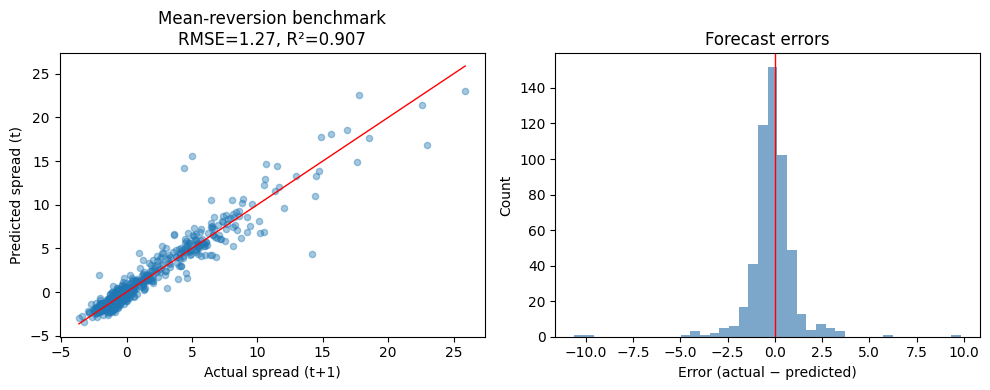

In [ ]:
# mean-reversion as benchmark

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

full = pd.read_pickle("saved/df.dat")[["country", "year", "tgt_spread_t1", "tgt_spread"]].dropna()
fullte = full[full["year"] >= 2015]
y_true = fullte["tgt_spread_t1"]
y_pred = fullte["tgt_spread"]

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2   = r2_score(y_true, y_pred)

# show fit and prediction error

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=100)
axes[0].scatter(y_true, y_pred, alpha=0.4, s=20)
axes[0].plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()],
             color="red", linestyle="-", lw=1)
axes[0].set_xlabel("Actual spread (t+1)")
axes[0].set_ylabel("Predicted spread (t)")
axes[0].set_title(f"Mean-reversion benchmark\nRMSE={rmse:.2f}, R²={r2:.3f}")

errors = y_true - y_pred
axes[1].hist(errors, bins=40, color="steelblue", alpha=0.7)
axes[1].axvline(0, color="red", lw=1)
axes[1].set_title("Forecast errors")
axes[1].set_xlabel("Error (actual − predicted)")
axes[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

# how much of total variance is explained by between-country variance

df = fullte[["country", "tgt_spread_lag"]].dropna()
overall_mean = df["tgt_spread_lag"].mean()
n_i = df.groupby("country")["tgt_spread_lag"].count()
means_i = df.groupby("country")["tgt_spread_lag"].mean()

# weighted between-country variance

sst_between = ((n_i * (means_i - overall_mean)**2).sum()) / (len(df) - 1)
sst_total = ((df["tgt_spread_lag"] - overall_mean)**2).sum() / (len(df) - 1)
print(f"Share of between-country variance in total variance: {sst_between / sst_total:.2%}")

### Incremental signal

In [ ]:
# Load
df = pd.read_pickle("saved/df.dat")

# Define columns
id_cols = ["country","year","iso_code_1","iso_code_2","region"]
exclude = id_cols + [c for c in df.columns if c.startswith("tgt_")]
macro_cols = filter_cols([c for c in df.columns if c.startswith("wb_") and not c.startswith("wb_iq_") and c not in exclude], [])
iq_cols = filter_cols([c for c in df.columns if (c.startswith("wb_iq_") or (not c.startswith("wb_") and c not in exclude))], [])

# Add today's spread level as explanatory variable
macro_cols += ["tgt_spread"]

# Run specification
results = run_unified_regularized_regression(
    name_prefix="signal",
    data_path="saved/df.dat",
    macro_cols=macro_cols,
    iq_cols=iq_cols,
    use_clustering=True,
    corr_threshold=0.85,
    y_name="tgt_spread_t1",
    spread_col="tgt_spread",
    year_col="year",
    split_year=2015,
    model_types=['lasso', 'ridge'],
    agnostic=False,
    param_factors=np.logspace(-3, 10, 25),
    l1_ratios=[0.25, 0.5, 0.75],
    use_expanding_cv=True,
    min_train_years=8,
    cv_stride=2,
    r2_benchmark=0.887,
    rmse_benchmark=1.36,
    early_stop_threshold=0.10,
    save_results=True,
    output_dir="specs",
    n_jobs=-1
)


UNIFIED REGULARIZED REGRESSION: SIGNAL
Research Question: Do macro/IQ variables add incremental predictive power beyond mean reversion?
Specification: β=1 (fixed at mean reversion)
Models: LASSO, RIDGE
Feature clustering: ON (threshold=0.85)
Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)
R² convergence: Stop after 2 consecutive changes < 0.0001

Train: 1960-2015 (1706 obs)
Test:  2016-2023 (477 obs)

β=1 specification: predicting (spread_t+1 - spread_t)
After removing NaN: 1628 train, 470 test obs

MULTICOLLINEARITY DIAGNOSTICS (Core Variables Only)



KeyboardInterrupt: 

### Priced-in level

In [ ]:
from functions.utils import filter_cols

# Load
df = pd.read_pickle("saved/df.dat")

# Define columns
id_cols = ["country", "year", "iso_code_1", "iso_code_2", "region"]
exclude = id_cols + [c for c in df.columns if c.startswith("tgt_")]
macro_cols = filter_cols([c for c in df.columns if c.startswith("wb_") and not c.startswith("wb_iq_") and c not in exclude], [])
iq_cols = filter_cols([c for c in df.columns if (c.startswith("wb_iq_") or (not c.startswith("wb_") and c not in exclude))], [])

# Run specification
results = run_unified_regularized_regression(
    name_prefix="levels",
    data_path="saved/df.dat",
    macro_cols=macro_cols,
    iq_cols=iq_cols,
    use_clustering=True,
    corr_threshold=0.9,
    y_name="tgt_spread",
    spread_col="tgt_spread",
    year_col="year",
    split_year=2015,
    model_types=['lasso', 'ridge', 'elastic'],
    agnostic=True,
    param_factors=np.logspace(-2, 5, 15),
    l1_ratios=[0.25, 0.5, 0.75],
    use_expanding_cv=True,
    min_train_years=8,
    cv_stride=2,
    r2_benchmark=None,
    rmse_benchmark=None,
    early_stop_threshold=0.10,
    save_results=False,
    output_dir="specs",
    n_jobs=-1
)


UNIFIED REGULARIZED REGRESSION: LEVELS
Research Question: What macro/IQ variables are priced into spreads?
Specification: Agnostic (β unrestricted)
Models: LASSO, RIDGE, ELASTIC
Elastic Net L1 ratios: [0.25, 0.5, 0.75]
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2015 (1652 obs)
Test:  2016-2024 (541 obs)

MULTICOLLINEARITY DIAGNOSTICS (Core Variables Only)

Found 60 core variable pairs with correlation above 0.9:



,core_variable_1,core_variable_2,correlation
0,p5d_democ,p5d_xconst,0.999063
1,wb_fp_cpi_totl_zg,wb_ny_gdp_defl_kd_zg,0.999056
2,p5d_xrreg,p5d_xconst,0.998977
3,p5d_democ,p5d_xrreg,0.997217
4,p5d_autoc,p5d_xrreg,0.997004
5,p5d_autoc,p5d_xconst,0.993404
6,p5d_democ,p5d_autoc,0.989513
7,fiw_b,fiw_pr,0.988235
8,fiw_cl,fiw_f,0.976274
9,fiw_a,fiw_pr,0.974487



Note: These correlations are reported for transparency.
Regularization handles multicollinearity. Interpretation focuses on stable patterns.

Clustering variants of same variables...
  Original features: 972
  After clustering: 634
  Number of clusters: 634

Features used in models: 634


--------------------------------------------------------------------------------
RUNNING LASSO
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.003793

Stopping: model has 0 active variables at factor 3162.2776601683795



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.000038,0.963680,-0.100415,4.396000,632,NaN,NaN
1,0.031623,0.000120,0.963665,-0.084150,4.363390,629,NaN,NaN
2,0.100000,0.000379,0.963350,-0.049959,4.294035,605,NaN,NaN
3,0.316228,0.001199,0.961327,-0.009447,4.210379,542,NaN,NaN
4,1.000000,0.003793,0.954384,0.178697,3.797790,446,NaN,NaN
5,3.162278,0.011994,0.939810,0.432268,3.157555,329,NaN,NaN
6,10.000000,0.037927,0.915739,0.472107,3.044755,203,NaN,NaN
7,31.622777,0.119935,0.862338,0.495854,2.975484,86,NaN,NaN
8,100.000000,0.379269,0.790401,0.514568,2.919736,24,NaN,NaN
9,316.227766,1.199354,0.680979,0.303349,3.497735,7,NaN,NaN



Best LASSO:
  Parameter: 0.379269
  R² (test): 0.5146
  RMSE (test): 2.9197
  Active vars: 24

INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(LASSO)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 19 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.564296,21.183727,5
74,ief_monetary_freedom,"[ief_monetary_freedom_t-3, ief_monetary_freedo...",0.561254,21.069518,7
12,efw_2d_military_interference,"[efw_2d_military_interference_ma10, efw_2d_mil...",0.302574,11.358659,5
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5...,0.253023,9.498501,7
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma5, wb_bn_cab_xoka_gd_z...",0.245889,9.230686,7
10,efw_2b_impartial_courts,"[efw_2b_impartial_courts_ma3, efw_2b_impartial...",0.166839,6.263139,5
88,wb_fp_cpi_totl_zg,"[wb_fp_cpi_totl_zg, wb_fp_cpi_totl_zg_ma10, wb...",0.152605,5.728794,6
19,efw_3b_standard_deviation_of_inflation,"[efw_3b_standard_deviation_of_inflation_t-1, e...",0.105727,3.968998,8
38,efw_5aii_private_sector_credit,"[efw_5aii_private_sector_credit_ma3, efw_5aii_...",0.055045,2.066408,8
99,wb_ny_gdp_petr_rt_zs,"[wb_ny_gdp_petr_rt_zs_delta, wb_ny_gdp_petr_rt...",0.050091,1.880408,5



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 8 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
0,efw_2d_military_interference,[efw_2d_military_interference_ma10],1.000,-0.340850,0.083244,1
1,efw_2e_legal_integrity,[efw_2e_legal_integrity_ma10],1.000,-0.637692,0.130343,1
5,wb_bn_cab_xoka_gd_zs,[wb_bn_cab_xoka_gd_zs_ma5],1.000,-0.328675,0.052443,1
4,ief_monetary_freedom,[ief_monetary_freedom_t-3],0.970,-0.793808,0.354935,1
2,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5],0.930,-0.114641,0.059240,1
3,efw_4c_black_market_exchange_rates,"[efw_4c_black_market_exchange_rates_ma10, efw_...",0.895,-0.154545,0.078826,2
6,wb_ny_gdp_petr_rt_zs,[wb_ny_gdp_petr_rt_zs_delta],0.800,0.272866,0.069735,1



--------------------------------------------------------------------------------
RUNNING RIDGE
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 174.867862



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,1.748679e+00,0.961864,-0.000488,4.191653,634,NaN,NaN
1,0.031623,5.529807e+00,0.958190,0.061217,4.060336,634,NaN,NaN
2,0.100000,1.748679e+01,0.951627,0.194124,3.761953,634,NaN,NaN
3,0.316228,5.529807e+01,0.940659,0.336398,3.413761,634,NaN,NaN
4,1.000000,1.748679e+02,0.923693,0.430671,3.161994,634,NaN,NaN
5,3.162278,5.529807e+02,0.897645,0.488617,2.996765,634,NaN,NaN
6,10.000000,1.748679e+03,0.851113,0.535431,2.856306,634,NaN,NaN
7,31.622777,5.529807e+03,0.744029,0.554868,2.795915,634,NaN,NaN
8,100.000000,1.748679e+04,0.537628,0.524745,2.888967,634,NaN,NaN
9,316.227766,5.529807e+04,0.316116,0.460726,3.077403,634,NaN,NaN



Best RIDGE:
  Parameter: 5529.807340
  R² (test): 0.5549
  RMSE (test): 2.7959
  Active vars: 634

INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(RIDGE)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",0.494245,4.847237,9
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma5, wb_bn_cab_xoka_gd_z...",0.335004,3.285497,7
74,ief_monetary_freedom,"[ief_monetary_freedom_t-3, ief_monetary_freedo...",0.274670,2.693782,7
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5...,0.252809,2.479386,7
58,efw_ie_state_ownership,"[efw_ie_state_ownership_ma10, efw_ie_state_own...",0.251828,2.469765,7
38,efw_5aii_private_sector_credit,"[efw_5aii_private_sector_credit_t-1, efw_5aii_...",0.247966,2.431892,8
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_ma5, efw_1b_tr...",0.219330,2.151048,6
10,efw_2b_impartial_courts,"[efw_2b_impartial_courts_delta3, efw_2b_impart...",0.218597,2.143857,5
33,efw_4diii_freedom_of_foreigners_to_visit,"[efw_4diii_freedom_of_foreigners_to_visit_t-3,...",0.198621,1.947943,6
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.192163,1.884608,5



METHOD 2: STABILITY SELECTION

Skipping stability selection for Ridge regression.
Ridge does not perform variable selection - all features have non-zero coefficients.
For feature importance with Ridge, refer to SHAP values above.


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1 ratio=0.25)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.003793

Stopping: model has 0 active variables at factor 10000.0



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p,l1_ratio
0,0.010000,0.000038,0.963678,-0.102981,4.401122,634,NaN,NaN,0.25
1,0.031623,0.000120,0.963653,-0.085342,4.365789,633,NaN,NaN,0.25
2,0.100000,0.000379,0.963390,-0.050065,4.294252,631,NaN,NaN,0.25
3,0.316228,0.001199,0.961672,0.011039,4.167436,608,NaN,NaN,0.25
4,1.000000,0.003793,0.956859,0.098377,3.979165,569,NaN,NaN,0.25
5,3.162278,0.011994,0.947802,0.293544,3.522264,505,NaN,NaN,0.25
6,10.000000,0.037927,0.931405,0.432754,3.156206,407,NaN,NaN,0.25
7,31.622777,0.119935,0.904009,0.479872,3.022280,297,NaN,NaN,0.25
8,100.000000,0.379269,0.849222,0.508562,2.937741,181,NaN,NaN,0.25
9,316.227766,1.199354,0.761361,0.499990,2.963254,88,NaN,NaN,0.25



Best ELASTIC (L1=0.25):
  Parameter: 0.379269
  R² (test): 0.5086
  RMSE (test): 2.9377
  Active vars: 181

INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(ELASTIC, L1=0.25)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
74,ief_monetary_freedom,"[ief_monetary_freedom_t-3, ief_monetary_freedo...",0.620143,7.928968,7
19,efw_3b_standard_deviation_of_inflation,"[efw_3b_standard_deviation_of_inflation_t-1, e...",0.385783,4.932502,8
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_ma5, efw_1b_tr...",0.368986,4.717745,6
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma5, wb_bn_cab_xoka_gd_z...",0.364376,4.658797,7
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",0.350585,4.482479,9
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5...,0.303633,3.882155,7
38,efw_5aii_private_sector_credit,"[efw_5aii_private_sector_credit_ma3, efw_5aii_...",0.231827,2.964075,8
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.228749,2.924718,5
31,efw_4di_financial_openness,"[efw_4di_financial_openness_t-5, efw_4di_finan...",0.224732,2.873356,7
12,efw_2d_military_interference,"[efw_2d_military_interference_ma10, efw_2d_mil...",0.200197,2.559661,5



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 104 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
4,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,1.000000,-0.155814,0.030632,1
6,efw_2b_impartial_courts,[efw_2b_impartial_courts_ma3],1.000000,-0.121949,0.030020,1
5,efw_2a_judicial_independence,[efw_2a_judicial_independence_ma10],1.000000,-0.149647,0.042592,1
40,p5d_durable,[p5d_durable],1.000000,-0.137484,0.030460,1
45,wb_ny_gdp_minr_rt_zs,"[wb_ny_gdp_minr_rt_zs_t-5, wb_ny_gdp_minr_rt_z...",0.995000,0.062058,0.022937,2
47,wb_ny_gdp_pcap_kd,"[wb_ny_gdp_pcap_kd, wb_ny_gdp_pcap_kd_delta]",0.990000,-0.082787,0.023595,2
42,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_t-3, wb_bn_cab_xoka_gd_z...",0.990000,-0.068413,0.030326,4
51,wb_tx_val_fuel_zs_un,"[wb_tx_val_fuel_zs_un_ma10, wb_tx_val_fuel_zs_...",0.985000,0.075988,0.029394,2
32,efw_ie_state_ownership,[efw_ie_state_ownership_ma10],0.980000,-0.222067,0.068203,1
36,ief_monetary_freedom,"[ief_monetary_freedom_t-3, ief_monetary_freedo...",0.980000,-0.166595,0.084016,4



--------------------------------------------------------------------------------
RUNNING ELASTIC (L1 ratio=0.5)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.003793

Stopping: model has 0 active variables at factor 3162.2776601683795



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p,l1_ratio
0,0.010000,0.000038,0.963678,-0.099957,4.395084,634,NaN,NaN,0.5
1,0.031623,0.000120,0.963658,-0.085576,4.366258,634,NaN,NaN,0.5
2,0.100000,0.000379,0.963393,-0.048819,4.291702,624,NaN,NaN,0.5
3,0.316228,0.001199,0.961584,0.016022,4.156925,577,NaN,NaN,0.5
4,1.000000,0.003793,0.955930,0.131464,3.905470,518,NaN,NaN,0.5
5,3.162278,0.011994,0.944683,0.352732,3.371488,428,NaN,NaN,0.5
6,10.000000,0.037927,0.924965,0.463164,3.070438,303,NaN,NaN,0.5
7,31.622777,0.119935,0.888626,0.497679,2.970094,196,NaN,NaN,0.5
8,100.000000,0.379269,0.820254,0.509748,2.934197,80,NaN,NaN,0.5
9,316.227766,1.199354,0.726070,0.435110,3.149644,40,NaN,NaN,0.5



Best ELASTIC (L1=0.5):
  Parameter: 0.379269
  R² (test): 0.5097
  RMSE (test): 2.9342
  Active vars: 80

INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(ELASTIC, L1=0.5)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
74,ief_monetary_freedom,"[ief_monetary_freedom_t-3, ief_monetary_freedo...",0.546426,12.318291,7
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma5, wb_bn_cab_xoka_gd_z...",0.353336,7.965386,7
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5...,0.261060,5.885170,7
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.254002,5.726058,5
12,efw_2d_military_interference,"[efw_2d_military_interference_ma10, efw_2d_mil...",0.247397,5.577171,5
19,efw_3b_standard_deviation_of_inflation,"[efw_3b_standard_deviation_of_inflation_t-1, e...",0.241654,5.447697,8
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",0.205463,4.631834,9
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_t-3, efw_1b_tr...",0.191706,4.321711,6
38,efw_5aii_private_sector_credit,"[efw_5aii_private_sector_credit_ma3, efw_5aii_...",0.144621,3.260244,8
7,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.138701,3.126791,5



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 44 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
1,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,1.000000,-0.153153,0.050417,1
2,efw_2b_impartial_courts,[efw_2b_impartial_courts_ma3],1.000000,-0.130797,0.043620,1
3,efw_2d_military_interference,[efw_2d_military_interference_ma10],1.000000,-0.270869,0.057867,1
4,efw_2e_legal_integrity,[efw_2e_legal_integrity_ma10],1.000000,-0.294900,0.037666,1
12,efw_5ciii_impartial_public_administration,[efw_5ciii_impartial_public_administration_ma10],1.000000,-0.112567,0.043716,1
8,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5],0.990000,-0.121914,0.046067,1
0,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_t-3, efw_1b_tr...",0.990000,0.093960,0.037128,2
16,ief_monetary_freedom,"[ief_monetary_freedom_t-3, ief_monetary_freedo...",0.973333,-0.305182,0.118028,3
11,efw_5aii_private_sector_credit,[efw_5aii_private_sector_credit_ma3],0.960000,-0.103735,0.041902,1
7,efw_4aiii_standard_deviation_of_tariff_rates,[efw_4aiii_standard_deviation_of_tariff_rates],0.960000,0.055161,0.023858,1



--------------------------------------------------------------------------------
RUNNING ELASTIC (L1 ratio=0.75)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...


KeyboardInterrupt: 